In [148]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tensorflow import keras
from torch.utils.data import Dataset
import torch.nn.functional as F

In [149]:
class MNISTDataset(Dataset):
    def __init__(self, image, label):
        self.image = torch.tensor(image, dtype = torch.float32)
        self.label = label

    def __len__(self): return len(self.label)

    def __getitem__(self, idx):
        image_ = self.image[idx]
        image_ = image_[None, :]
        label_ = self.label[idx]
        return image_, label_
        

In [150]:
(x_tr, y_tr), (x_ts, y_ts) = keras.datasets.mnist.load_data()
x_tr, y_tr = x_tr[0:6400], y_tr[0:6400]
x_ts, y_ts = x_ts[0:640], y_ts[0:640]

In [151]:

trainset = MNISTDataset(x_tr, y_tr)
valset = MNISTDataset(x_ts, y_ts)

In [152]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [153]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [154]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [155]:
n_epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 5

In [156]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [157]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]

In [158]:
y_tr[4]

9

In [159]:
# from torch.autograd import grad

# def nth_derivative(f, wrt, n):

#     for i in range(n):

#         grads = grad(f, wrt, create_graph=True)[0]
#         f = grads.sum()

#     return grads

In [160]:
derivative = [[]]*10
# new_derivative = []*10

def train(epoch):
  
  i = 0
  network.train()
  for batch_idx, (data, target) in enumerate(trainloader):
    data.requires_grad_(True)
    
    optimizer.zero_grad()
    output = network(data)
    # print(output.shape)
    
    loss = F.nll_loss(output, target)
    loss.backward(retain_graph=True)
    
    first_derivative = data.grad
    # print(first_derivative.shape) # 64*1*28*28
    first_derivative = first_derivative.view(64, -1)
    # print(first_derivative[1].shape) # 64, 784
    
    # print(i)  
    for j in range(len(first_derivative)):
        # print(len(first_derivative))
        derivative[y_tr[i]].append(first_derivative[j])
        i += 1
    # print(i)  
    
      
    loss_all = []
    for j in range(10):
        temp = torch.stack(derivative[j])
        # print(temp.shape)
        mean = torch.mean(temp, dim = 0)
        # print(mean.shape)
        # print(derivative[0][0].shape)
        l = 0
        for k in range(len(derivative[j])):
            loss2 = torch.nn.MSELoss()
            l += loss2(mean, derivative[j][k])
        loss_all.append(l)
    
    # print(loss_all)
    derivative_loss = 10*sum(loss_all)
    loss += derivative_loss
    loss.backward(retain_graph=True)

    optimizer.step()
    if batch_idx % log_interval == 0:
      print("derivative loss:", derivative_loss)
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(trainloader.dataset),
        100. * batch_idx / len(trainloader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
         (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))
    
    # derivative = new_derivative
    # new_derivative = []*10

In [161]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in valloader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(valloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(valloader.dataset),
    100. * correct / len(valloader.dataset)))

In [162]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_790/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 15.7158, Accuracy: 61/640 (10%)

derivative loss: tensor(3.3339e-05)
Train Epoch: 1 [0/6400 (0%)]	Loss: 21.824171
derivative loss: tensor(0.0012)
Train Epoch: 1 [320/6400 (5%)]	Loss: 2.293024
derivative loss: tensor(0.0019)
Train Epoch: 1 [640/6400 (10%)]	Loss: 2.307087
derivative loss: tensor(0.0029)
Train Epoch: 1 [960/6400 (15%)]	Loss: 2.220138
derivative loss: tensor(0.0039)
Train Epoch: 1 [1280/6400 (20%)]	Loss: 2.237751
derivative loss: tensor(0.0050)
Train Epoch: 1 [1600/6400 (25%)]	Loss: 2.133295
derivative loss: tensor(0.0060)
Train Epoch: 1 [1920/6400 (30%)]	Loss: 1.990435
derivative loss: tensor(0.0067)
Train Epoch: 1 [2240/6400 (35%)]	Loss: 1.894405
derivative loss: tensor(0.0075)
Train Epoch: 1 [2560/6400 (40%)]	Loss: 1.819620
derivative loss: tensor(0.0082)
Train Epoch: 1 [2880/6400 (45%)]	Loss: 1.787635
derivative loss: tensor(0.0090)
Train Epoch: 1 [3200/6400 (50%)]	Loss: 1.546015
derivative loss: tensor(0.0100)
Train Epoch: 1 [3520/6400 (55%)]	Los

In [ ]:
def scores(loader):
    network.eval()
    # outputs = [] 
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = network(data)
            # outputs.append(output)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    return output

In [164]:
trloader = torch.utils.data.DataLoader(trainset, batch_size=6400, shuffle=False)
tsloader = torch.utils.data.DataLoader(valset, batch_size=640, shuffle=False)

In [165]:
train_score = scores(trloader)
test_score = scores(tsloader)

/tmp/ipykernel_790/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.4051, Accuracy: 5745/6400 (90%)


Test set: Avg. loss: 0.4823, Accuracy: 561/640 (88%)



In [166]:
train_score.shape

torch.Size([6400, 10])

In [167]:
torch.save(train_score, 'train_score_1_1.pt')
torch.save(test_score, 'test_score_1_1.pt')

In [168]:
train_score = torch.load('train_score.pt')
train_score.shape

torch.Size([60000, 10])

In [ ]:
y_tr[0:200].shape

(200,)

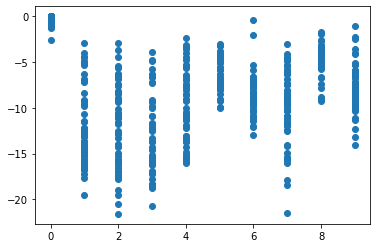

In [ ]:
plt.scatter(y_tr[0:500], train_score[0:500, 0])
plt.show()
# torch.scatter(train_score[0:200, 0], index = torch.from_numpy(y_tr[0:200]))